In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2
import pkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3, VGG16
from tensorflow.keras import Model

import sys
sys.path.append('/kaggle/input/helper-functions1')
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

2024-04-02 18:29:12.653635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 18:29:12.653694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 18:29:12.655546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading the images

In [2]:
# Declaring an empty list to store images and their respective labels
img_arr = []
label_arr = []

# Changing the current directory
os.chdir('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision')

# Specifying the directory that contains the images
directory = 'Data Combined'

# Iterating through the class folders
for class_folder in os.listdir(directory):
    if(class_folder.startswith(".")):
            continue

    # Iterating through the images
    for img in os.listdir(directory + "/" + class_folder):

        # Adding images to the list
        img_arr.append(directory + "/" + class_folder + "/" + img)

        # Adding labels to the list
        label_arr.append(class_folder)

# Verifying the shapes of the lists
print(np.array(img_arr).shape)
print(np.array(label_arr).shape)

# Adding the lists to a pandas dataframe
img_df = pd.DataFrame({'ImagePaths': img_arr, 'Labels': label_arr})

# Displaying the dataframe
img_df

(10000,)
(10000,)


,ImagePaths,Labels
0,Data Combined/DayZinc/00000503.jpg,DayZinc
1,Data Combined/DayZinc/00000888.jpg,DayZinc
2,Data Combined/DayZinc/00000399.jpg,DayZinc
3,Data Combined/DayZinc/00000390.jpg,DayZinc
4,Data Combined/DayZinc/00000601.jpg,DayZinc
...,...,...
9995,Data Combined/Bioflu/00000400.jpg,Bioflu
9996,Data Combined/Bioflu/00000593.jpg,Bioflu
9997,Data Combined/Bioflu/00000435.jpg,Bioflu
9998,Data Combined/Bioflu/00000405.jpg,Bioflu


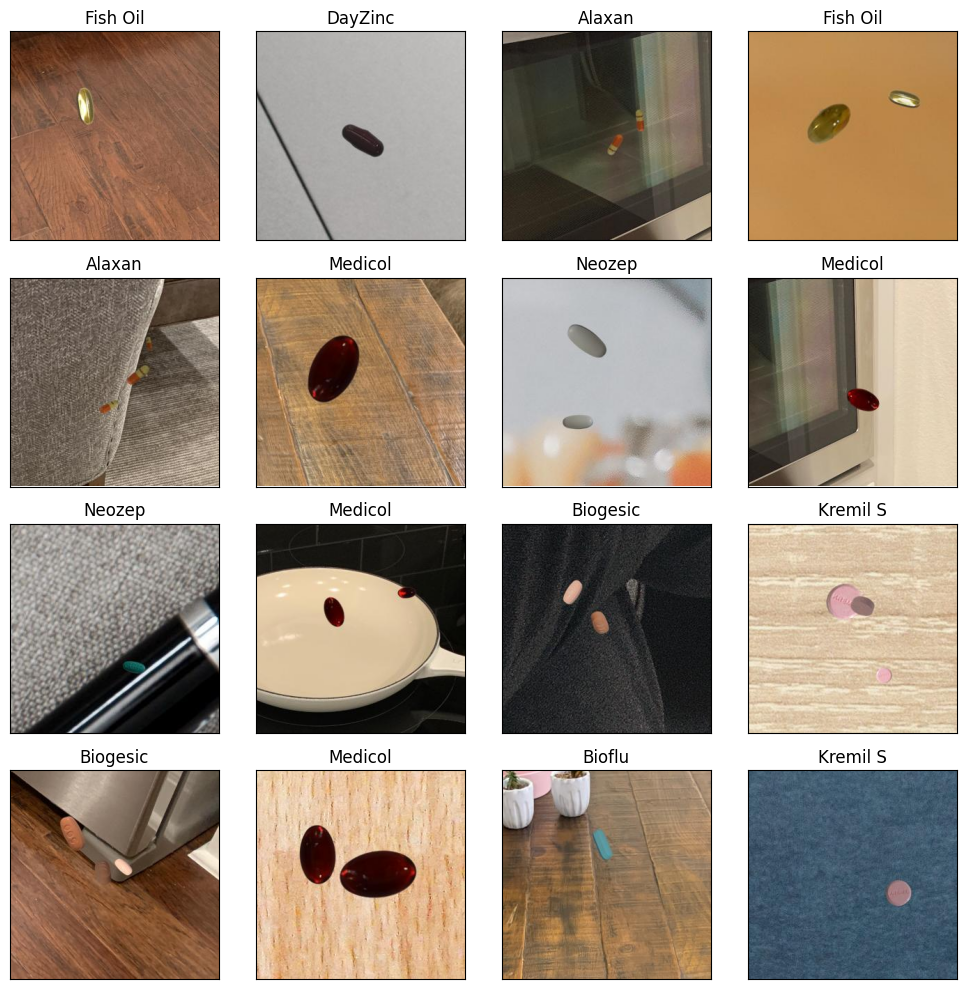

In [3]:
# Generating 16 random integers from 0 to 10000 (size of the image dataframe)
random_index = np.random.randint(0, len(img_df), 16)

# Creating a 4x4 matrix to plot 16 random images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

# Iterating through the subplots
for i, ax in enumerate(axes.flat):

    # Displaying the image
    ax.imshow(plt.imread(img_df.ImagePaths[random_index[i]]))

    # Displaying the title for the image
    ax.set_title(img_df.Labels[random_index[i]])

# Adding padding between the images
plt.tight_layout()
plt.show()

In [4]:
# Separate in train and test data
train_df, test_df = train_test_split(img_df, test_size=0.2, shuffle=True, random_state=42)

# Defining the pretrained input
# pretrained_input = tf.keras.applications.inception_v3.preprocess_input
# pretrained_input = tf.keras.applications.vgg16.preprocess_input
pretrained_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Creating an image generator for the train data
train_generator = ImageDataGenerator(preprocessing_function=pretrained_input, validation_split=0.2)

# Creating an image generator for the test data
test_generator = ImageDataGenerator(preprocessing_function=pretrained_input)

In [5]:
# Generating the train images
train_images = train_generator.flow_from_dataframe(
                                                  dataframe=train_df,
                                                  x_col='ImagePaths',
                                                  y_col='Labels',
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True,
                                                  seed=42,
                                                  subset='training'
                                                  )

# Generating the validation images
val_images = train_generator.flow_from_dataframe(
                                                dataframe=train_df,
                                                x_col='ImagePaths',
                                                y_col='Labels',
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=32,
                                                shuffle=True,
                                                seed=42,
                                                subset='validation'
                                                )

# Generating the test images
test_images = test_generator.flow_from_dataframe(
                                                dataframe=test_df,
                                                x_col='ImagePaths',
                                                y_col='Labels',
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=32,
                                                shuffle=False
                                                )

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [6]:
# Loading the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
                                                    input_shape=(224, 224, 3),
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg'
                                                    )

# Freezing all the weights
pretrained_model.trainable = False

In [7]:
# Defining the checkpoint path
checkpoint_path = "/kaggle/working/pharmaceutical_drug_classification_model_checkpoint.weights.h5"

# Saving the best weights to resume training from the state saved
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True)

# Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Creating a layer to resize and rescale the images
resize_and_rescale = tf.keras.Sequential([tf.keras.layers.Resizing(96, 96),
                                          tf.keras.layers.Rescaling(1.0/255)])

In [8]:
# Defining the input layer
ip = pretrained_model.input
# Adding the resizing and rescaling layer
x = resize_and_rescale(ip)

# Adding a dense layer with relu activation to the output of the pretrained layer
x = Dense(256, activation='relu')(pretrained_model.output)
# Adding a dropout layer
x = Dropout(0.2)(x)
# Adding a dense layer with relu activation to the output of the pretrained layer
x = Dense(256, activation='relu')(x)
# Adding a dropout layer
x = Dropout(0.2)(x)
# Defining the output layer
op = Dense(10, activation='softmax')(x)

# Creating the model
model = Model(inputs=ip, outputs=op)

# Compiling the model
model.compile(optimizer=Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history = model.fit(
                    train_images,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    epochs=300,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/300


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/200 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.0573 - loss: 2.6937 

I0000 00:00:1712082574.457186    2815 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.1009 - loss: 2.4804 - val_accuracy: 0.1950 - val_loss: 2.2014
Epoch 2/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/300


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.1863 - loss: 2.2403 - val_accuracy: 0.3650 - val_loss: 2.0054
Epoch 4/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 75us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.2812 - loss: 2.0509 - val_accuracy: 0.4681 - val_loss: 1.8157
Epoch 6/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.3703 - loss: 1.8771 - val_accuracy: 0.5487 - val_loss: 1.6299
Epoch 8/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.4494 - loss: 1.7085 - val_accuracy: 0.6112 - val_loss: 1.4585
Epoch 10/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 77u

In [9]:
# Evaluating the model
results = model.evaluate(test_images, verbose=0)

# Printing the loss and accuracy of the model on the test data
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.48616
Test Accuracy: 85.05%


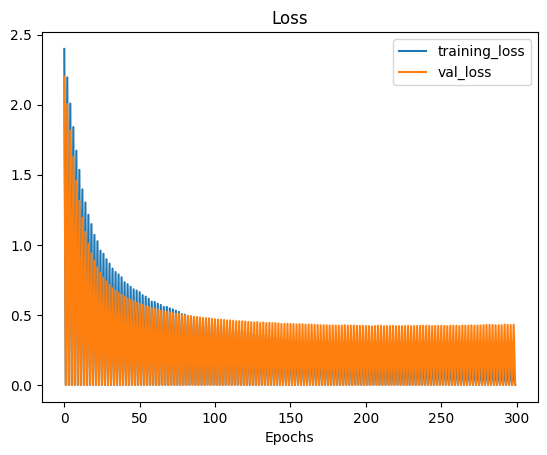

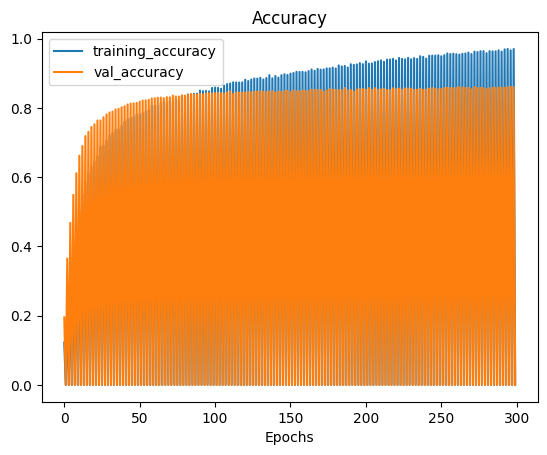

In [10]:
# Plotting the loss and accuracy of the model
plot_loss_curves(history)

In [11]:
# Predicting the labels of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapping the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step


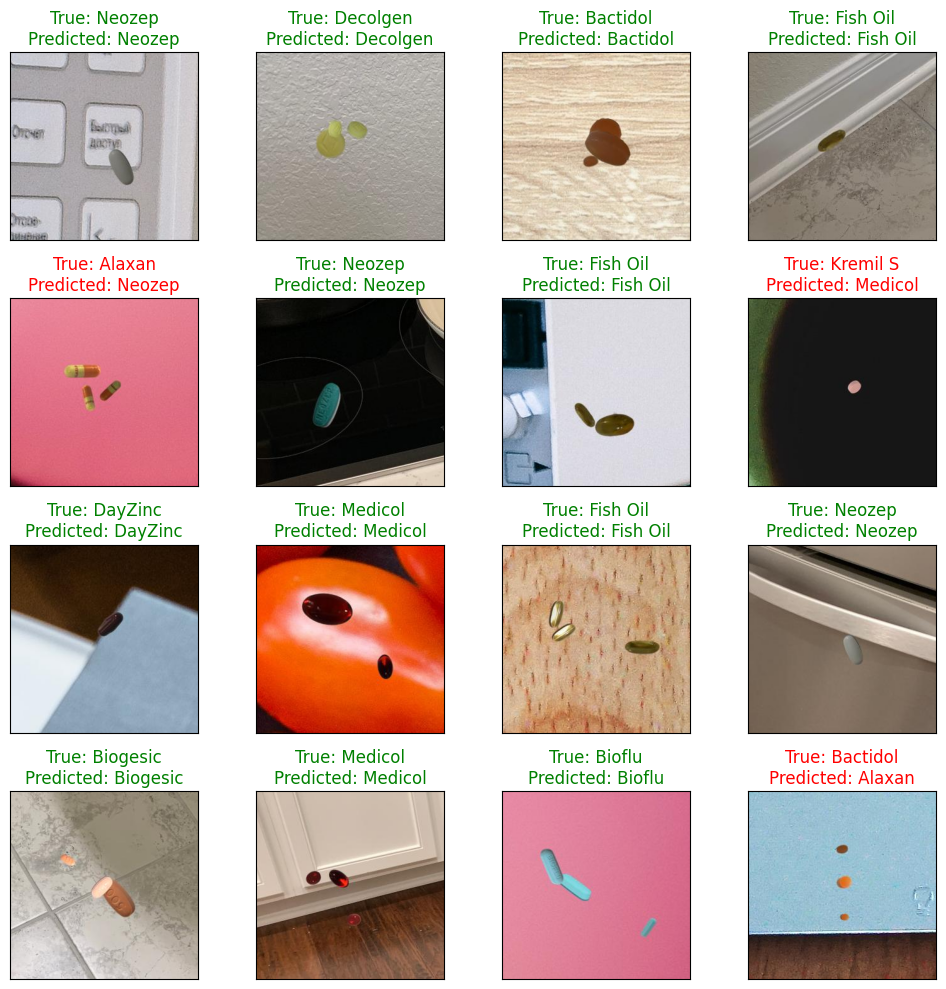

In [12]:
# Displaying 15 random images from the dataset and comparing their labels with the predictions
random_index = np.random.randint(0, len(test_df) - 1, 16)

# Creating a 4x4 matrix to plot 16 random images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

# Iterating through the subplots
for i, ax in enumerate(axes.flat):

    # Displaying the image
    ax.imshow(plt.imread(test_df.ImagePaths.iloc[random_index[i]]))

    # Checking if the prediction matches the label
    if test_df.Labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"

    # Checking if the prediction does not match the label
    else:
        color = "red"

    # Displaying the title for the image
    ax.set_title(f"True: {test_df.Labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

# Adding padding between the images
plt.tight_layout()
plt.show()